In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.optimizers import Adam,  Adagrad
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

Generar espectrogramas de MEL

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
def convertir_a_espectrograma(input_folder, output_folder):
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            audio_path = os.path.join(root, file)

            y, sr = librosa.load(audio_path, sr=None) 

            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            output_path = os.path.join(output_folder, file.replace('.wav', '_mel.png'))
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Espectrograma de Mel')
            plt.tight_layout()
            plt.savefig(output_path)
            plt.close()

input_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/FMA_WAVs'
output_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/FMA_MEL'
##
#input_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/GTZAN/Data/genres_original'
#output_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/GTZAN/Data/images_original'
#

convertir_a_espectrograma(input_folder_path, output_folder_path)


Cargar datos a los modelos

In [4]:
def cargar_datos(input_folder):
    datos = []
    etiquetas = []

    for genero in os.listdir(input_folder):
        genero_path = os.path.join(input_folder, genero)

        for archivo in os.listdir(genero_path):
            archivo_path = os.path.join(genero_path, archivo)
            img = image.load_img(archivo_path, target_size=(128, 128))  
            img_array = image.img_to_array(img)
            datos.append(img_array)
            etiquetas.append(genero)

    datos = np.array(datos)
    etiquetas = np.array(etiquetas)

    return datos, etiquetas


Modelo VGG16 con optimizador ADAM

GTZAN:

Epoch 1/10
25/25 [==============================] - 81s 3s/step - loss: 2.1856 - accuracy: 0.2528 - val_loss: 2.0544 - val_accuracy: 0.3100
Epoch 2/10
25/25 [==============================] - 64s 3s/step - loss: 1.7700 - accuracy: 0.4130 - val_loss: 1.7738 - val_accuracy: 0.4000
Epoch 3/10
25/25 [==============================] - 69s 3s/step - loss: 1.5401 - accuracy: 0.4693 - val_loss: 1.6585 - val_accuracy: 0.4200
Epoch 4/10
25/25 [==============================] - 69s 3s/step - loss: 1.4517 - accuracy: 0.5069 - val_loss: 1.5722 - val_accuracy: 0.4450
Epoch 5/10
25/25 [==============================] - 81s 3s/step - loss: 1.3117 - accuracy: 0.5469 - val_loss: 1.4834 - val_accuracy: 0.5450
Epoch 6/10
25/25 [==============================] - 66s 3s/step - loss: 1.2287 - accuracy: 0.6083 - val_loss: 1.4199 - val_accuracy: 0.4850
Epoch 7/10
25/25 [==============================] - 68s 3s/step - loss: 1.2048 - accuracy: 0.5732 - val_loss: 1.4150 - val_accuracy: 0.4750
Epoch 8/10
25/25 [==

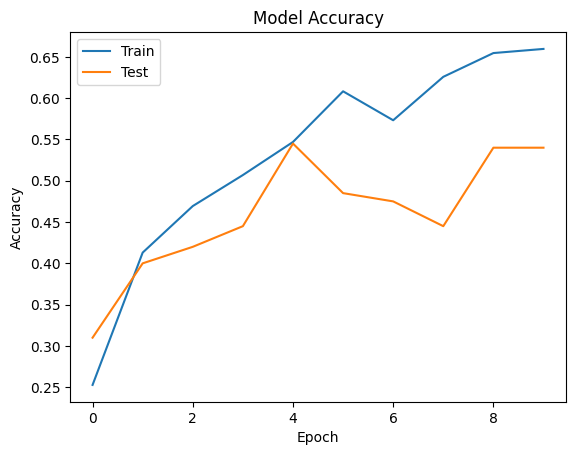

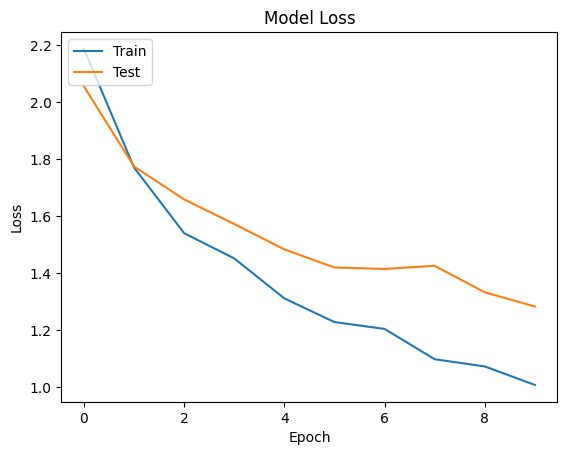

7/7 [==============================] - 18s 2s/step


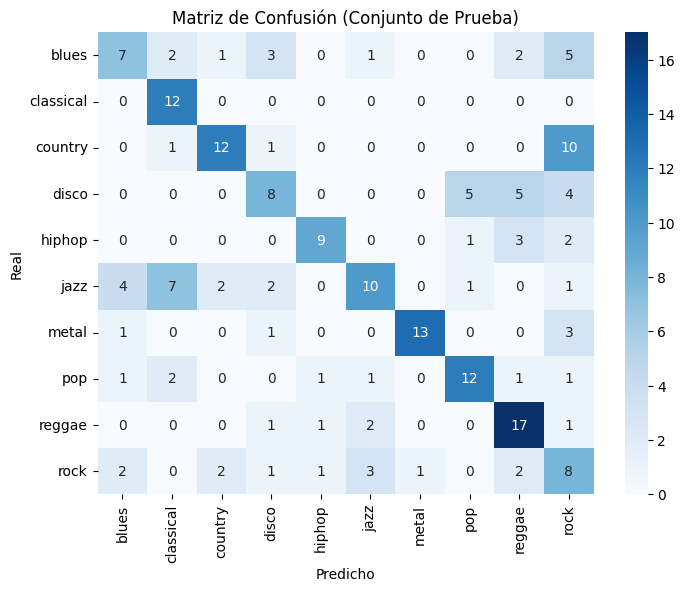

F-score: 0.5417080632781852
Precision: 0.5798942577030812
Recall: 0.54


C:\Users\PAULO\Documents\GitHub\Music-Classifier\venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
input_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/GTZAN/Data/images_original'
output_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/GTZAN/Data'

# Cargar datos y etiquetas
X, y = cargar_datos(input_folder_path)

# Codificar las etiquetas
le = LabelEncoder()
y = le.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los valores de píxeles al rango [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Utilizar la arquitectura VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Construir el modelo de CNN con VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # 10 clases (géneros musicales)
])

# Compilar el modelo
ada = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=ada, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nAccuracy en el conjunto de prueba: {test_acc}')

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predicciones y métricas
y_pred = model.predict(X_test)
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = y_test  # No es necesario convertir a one-hot encoding para las métricas que estás utilizando

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión (Conjunto de Prueba)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Métricas adicionales
f_score = f1_score(y_test_binary, y_pred_binary, average='weighted')
precision = precision_score(y_test_binary, y_pred_binary, average='weighted')
recall = recall_score(y_test_binary, y_pred_binary, average='weighted')

print("F-score:", f_score)
print("Precision:", precision)
print("Recall:", recall)

# Guardar el modelo
model.save(output_folder_path + '/modelo_cnn_vgg16_gtzan.h5')


FMA:

Epoch 1/10
200/200 [==============================] - 639s 3s/step - loss: 1.8396 - accuracy: 0.3188 - val_loss: 1.7162 - val_accuracy: 0.3715
Epoch 2/10
200/200 [==============================] - 573s 3s/step - loss: 1.6033 - accuracy: 0.4172 - val_loss: 1.6894 - val_accuracy: 0.3734
Epoch 3/10
200/200 [==============================] - 529s 3s/step - loss: 1.5387 - accuracy: 0.4435 - val_loss: 1.6852 - val_accuracy: 0.3802
Epoch 4/10
200/200 [==============================] - 755s 4s/step - loss: 1.4776 - accuracy: 0.4696 - val_loss: 1.5579 - val_accuracy: 0.4284
Epoch 5/10
200/200 [==============================] - 788s 4s/step - loss: 1.4338 - accuracy: 0.4890 - val_loss: 1.5790 - val_accuracy: 0.4271
Epoch 6/10
200/200 [==============================] - 682s 3s/step - loss: 1.3985 - accuracy: 0.4959 - val_loss: 1.5557 - val_accuracy: 0.4384
Epoch 7/10
200/200 [==============================] - 595s 3s/step - loss: 1.3831 - accuracy: 0.5040 - val_loss: 1.6012 - val_accuracy: 0.4178

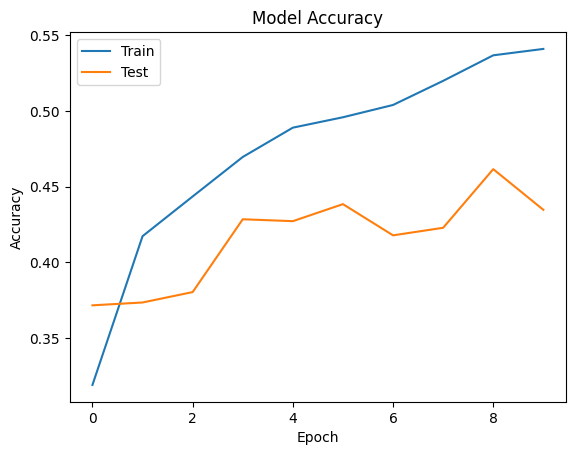

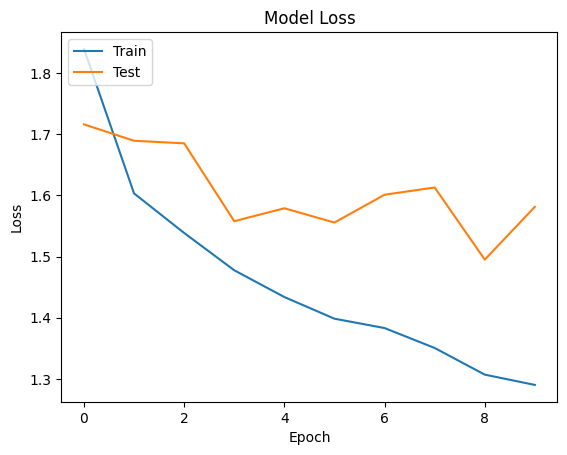

50/50 [==============================] - 116s 2s/step


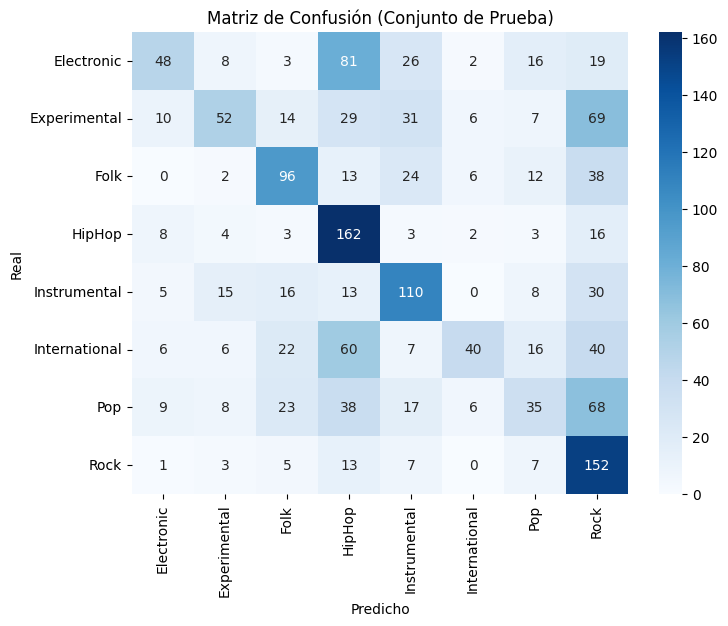

ValueError: Found input variables with inconsistent numbers of samples: [200, 1599]

In [13]:

# Rutas de las carpetas de entrada y salida
input_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/FMA_MEL'
output_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier'

# Cargar datos y etiquetas
X, y = cargar_datos(input_folder_path)

# Codificar las etiquetas
le = LabelEncoder()
y = le.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los valores de píxeles al rango [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Utilizar la arquitectura VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Construir el modelo de CNN con VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # 10 clases (géneros musicales)
])

# Compilar el modelo
ada = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=ada, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nAccuracy en el conjunto de prueba: {test_acc}')

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Matriz de confusión
y_pred = model.predict(X_test)
y_pred_binary = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión (Conjunto de Prueba)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Métricas adicionales
f_score = f1_score(y_test_binary, y_pred_binary, average='weighted')
precision = precision_score(y_test_binary, y_pred_binary, average='weighted')
recall = recall_score(y_test_binary, y_pred_binary, average='weighted')

print("F-score:", f_score)
print("Precision:", precision)
print("Recall:", recall)


test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Guardar el modelo
model.save(output_folder_path + '/modelo_cnn_vgg16_fma.h5')


Modelo VGG19 con optimizador Adagrad

GTZAN

Epoch 1/10
25/25 [==============================] - 89s 4s/step - loss: 2.3339 - accuracy: 0.1252 - val_loss: 2.2474 - val_accuracy: 0.2200
Epoch 2/10
25/25 [==============================] - 93s 4s/step - loss: 2.2124 - accuracy: 0.1940 - val_loss: 2.1843 - val_accuracy: 0.2250
Epoch 3/10
25/25 [==============================] - 97s 4s/step - loss: 2.1399 - accuracy: 0.2766 - val_loss: 2.1579 - val_accuracy: 0.2750
Epoch 4/10
25/25 [==============================] - 92s 4s/step - loss: 2.0874 - accuracy: 0.3029 - val_loss: 2.1099 - val_accuracy: 0.2800
Epoch 5/10
25/25 [==============================] - 102s 4s/step - loss: 2.0406 - accuracy: 0.3392 - val_loss: 2.0686 - val_accuracy: 0.2550
Epoch 6/10
25/25 [==============================] - 96s 4s/step - loss: 2.0035 - accuracy: 0.3579 - val_loss: 2.0717 - val_accuracy: 0.1850
Epoch 7/10
25/25 [==============================] - 96s 4s/step - loss: 1.9667 - accuracy: 0.3717 - val_loss: 2.0111 - val_accuracy: 0.3200
Epoch 8/10
25/25 [=

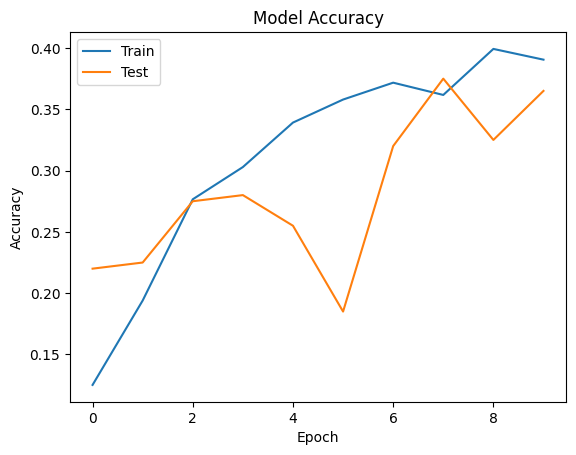

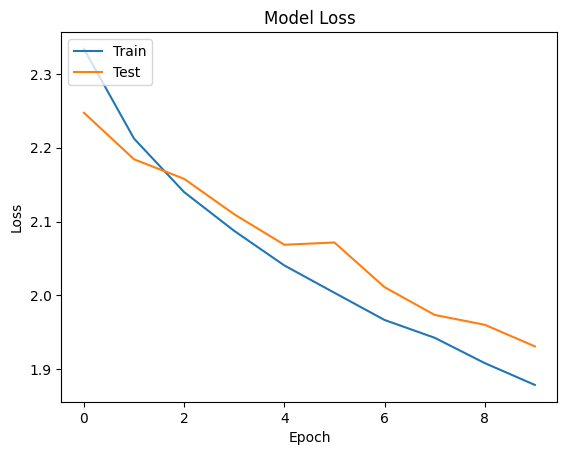

7/7 [==============================] - 17s 2s/step


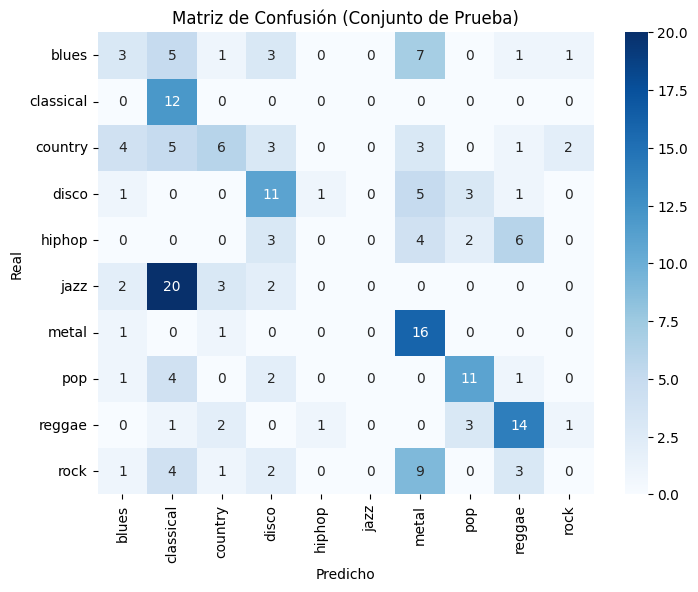

C:\Users\PAULO\Documents\GitHub\Music-Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F-score: 0.2940067138909893
Precision: 0.2810797590209355
Recall: 0.365
7/7 [==============================] - 16s 2s/step - loss: 1.9310 - accuracy: 0.3650
Test Loss: 1.9309712648391724
Test Accuracy: 0.36500000953674316


C:\Users\PAULO\Documents\GitHub\Music-Classifier\venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:


# Rutas de las carpetas de entrada y salida
input_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/GTZAN/Data/images_original'
output_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/GTZAN/Data'

# Cargar datos y etiquetas
X, y = cargar_datos(input_folder_path)

# Codificar las etiquetas
le = LabelEncoder()
y = le.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los valores de píxeles al rango [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Utilizar la arquitectura VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Construir el modelo de CNN con VGG19
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # 10 clases (géneros musicales)
])

# Compilar el modelo con Adagrad
adagrad_optimizer = Adagrad(learning_rate=0.001)
model.compile(optimizer=adagrad_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nAccuracy en el conjunto de prueba: {test_acc}')

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Matriz de confusión
y_pred = model.predict(X_test)
y_pred_binary = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión (Conjunto de Prueba)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Métricas adicionales
f_score = f1_score(y_test_binary, y_pred_binary, average='weighted')
precision = precision_score(y_test_binary, y_pred_binary, average='weighted')
recall = recall_score(y_test_binary, y_pred_binary, average='weighted')

print("F-score:", f_score)
print("Precision:", precision)
print("Recall:", recall)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Guardar el modelo
model.save(output_folder_path + '/modelo_cnn_vgg19_adagrad_gtzan.h5')


FMA:

Epoch 1/10
200/200 [==============================] - 746s 4s/step - loss: 1.9808 - accuracy: 0.2360 - val_loss: 1.8931 - val_accuracy: 0.3002
Epoch 2/10
200/200 [==============================] - 661s 3s/step - loss: 1.8458 - accuracy: 0.3184 - val_loss: 1.8354 - val_accuracy: 0.2958
Epoch 3/10
200/200 [==============================] - 666s 3s/step - loss: 1.7819 - accuracy: 0.3503 - val_loss: 1.7799 - val_accuracy: 0.3477
Epoch 4/10
200/200 [==============================] - 649s 3s/step - loss: 1.7424 - accuracy: 0.3659 - val_loss: 1.7489 - val_accuracy: 0.3721
Epoch 5/10
200/200 [==============================] - 645s 3s/step - loss: 1.7104 - accuracy: 0.3748 - val_loss: 1.7358 - val_accuracy: 0.3727
Epoch 6/10
200/200 [==============================] - 653s 3s/step - loss: 1.6879 - accuracy: 0.3875 - val_loss: 1.7128 - val_accuracy: 0.3615
Epoch 7/10
200/200 [==============================] - 651s 3s/step - loss: 1.6689 - accuracy: 0.3969 - val_loss: 1.6970 - val_accuracy: 0.3640

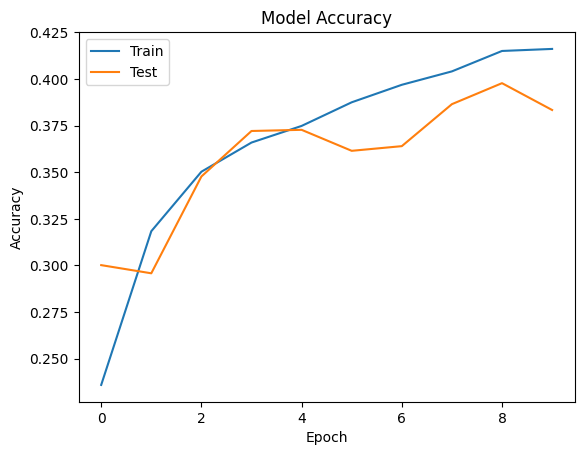

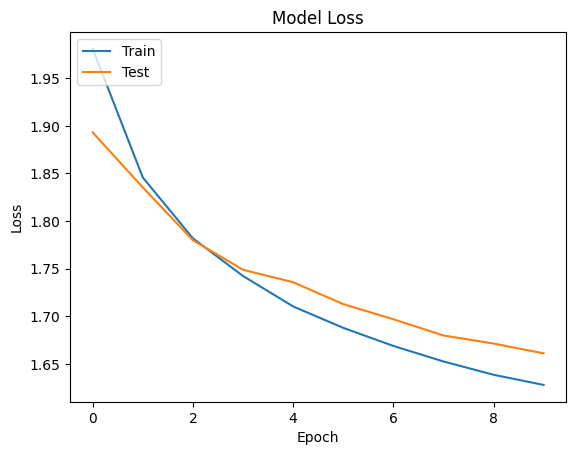

50/50 [==============================] - 129s 3s/step


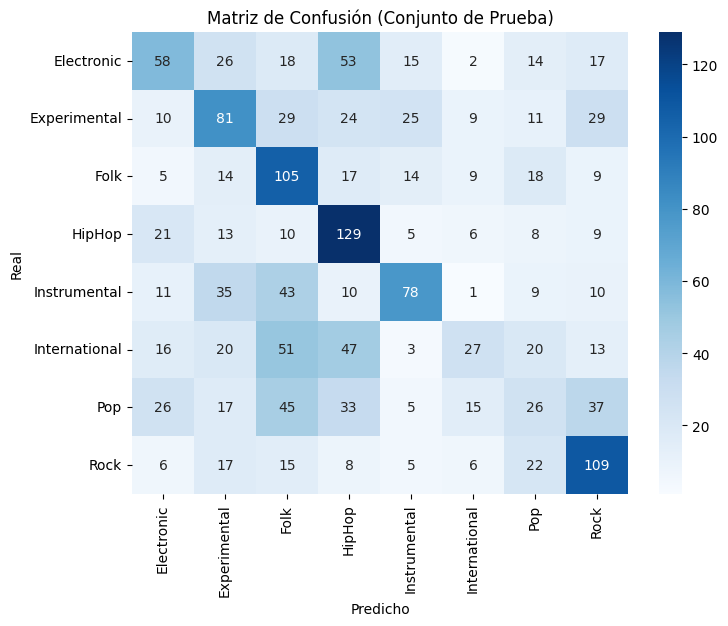

F-score: 0.3637655191880575
AUC: 0.7846866522876342
50/50 [==============================] - 126s 3s/step - loss: 1.6611 - accuracy: 0.3834
Test Loss: 1.6610891819000244
Test Accuracy: 0.38336458802223206


C:\Users\PAULO\Documents\GitHub\Music-Classifier\venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:

# Rutas de las carpetas de entrada y salida
input_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier/FMA_MEL'
output_folder_path = 'C:/Users/PAULO/Documents/GitHub/Music-Classifier'

# Cargar datos y etiquetas
X, y = cargar_datos(input_folder_path)

# Codificar las etiquetas
le = LabelEncoder()
y = le.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los valores de píxeles al rango [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Utilizar la arquitectura VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Construir el modelo de CNN con VGG19
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # 8 clases (géneros musicales)
])

# Compilar el modelo con Adagrad
adagrad_optimizer = Adagrad(learning_rate=0.001)
model.compile(optimizer=adagrad_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nAccuracy en el conjunto de prueba: {test_acc}')

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Matriz de confusión
y_pred = model.predict(X_test)
y_pred_binary = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión (Conjunto de Prueba)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Métricas adicionales
f_score = f1_score(y_test, y_pred_binary, average='weighted')


print("F-score:", f_score)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Guardar el modelo
model.save(output_folder_path + '/modelo_cnn_vgg19_adagrad_fma.h5')
